<a href="https://colab.research.google.com/github/rafsan-2018/Deep-Learning-Method-for-Breast-Cancer-Diagnosis/blob/main/breast_cancer_robust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # Import the drive module from google.colab
from google.colab import drive
import zipfile
import os
# Mount Google Drive to the specified directory '/content/drive'
drive.mount('/content/drive')

# incase you are not storing the file in google drive, set the FILE directory automatically.
# FILE_DIR = '';

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat Oct 12 13:30:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



```
# This is formatted as code
```

install necessaries libraries

In [ ]:
!pip install natsort
!pip install livelossplot
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7d6fbec2e5a5e8f474f6edeeba55510ba6a3d5ef6f42d57aabb6db59b781aa21
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


### **Importing the relevant libraries needed for model.**

In [ ]:
# Enable inline plotting in Jupyter notebooks
%matplotlib inline
# Standard Libraries
import os
import warnings
# Data Handling
import numpy as np
import pandas as pd
from glob import glob
from natsort import natsorted
# Image Processing Libraries
import cv2 as cv
from skimage import color
from skimage.filters import threshold_minimum, threshold_otsu
from skimage.segmentation import clear_border, mark_boundaries
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
# Data Visualization
import matplotlib.pyplot as plt
# Deep Learning Libraries
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
# Keras Preprocessing
from keras.preprocessing.image import load_img, img_to_array
# Model Building
from keras.models import Model
from keras.layers import (
    Layer,
    Conv2D,
    Dropout,
    UpSampling2D,
    concatenate,
    Add,
    Multiply,
    Input,
    MaxPool2D,
    BatchNormalization,
    Flatten,
    Activation,
    Conv2DTranspose,
    Concatenate,
    MaxPooling2D,
    Dense,
    GlobalAveragePooling2D
)
# Callbacks
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, CSVLogger
# Optimizers
from tensorflow.keras.optimizers import Adam
# Metrics
from keras.metrics import MeanIoU
from tensorflow.keras.metrics import Recall, Precision, Accuracy
# Explanation Tools
# from tf_explain.core.grad_cam import GradCAM
# Model Evaluation
from sklearn.model_selection import train_test_split
from natsort import natsorted
import re
from livelossplot import PlotLossesKeras
# Ignore warnings
warnings.filterwarnings("ignore")

### **mount the drive**

In [ ]:
zip_path = '/content/drive/MyDrive/Dataset_BUSI.zip'
extract_path = '/content/breast_data'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Data extracted to {extract_path}")

Data extracted to /content/breast_data


### **declaring utility functions to be used for loading, plotting and preprocessing.**

In [ ]:
def show_image(ax, image_path, title):
    """
    Show an image from the specified file path on a given axis with a title.

    Parameters:
    ax (matplotlib.axes.Axes): The axis on which to display the image.
    image_path (str): The path of the image file to be displayed.
    title (str): The title for the displayed image.
    """
    # Read the image from the file path
    image = cv.imread(image_path, cv.IMREAD_COLOR)
    # Convert the image from BGR to RGB
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    # Resize the image to 500x500 pixels
    resized_image = cv.resize(image_rgb, (256, 256), interpolation=cv.INTER_AREA)

    # Display the image on the specified axis
    ax.imshow(resized_image)
    ax.axis('off')  # Hide the axis
    ax.set_title(title)  # Set the title for the image

def show_image_read(axis, image, title):
    """
    Display an image on a specified axis with a title.

    Parameters:
    axis (matplotlib.axes.Axes): The axis on which to display the image.
    image (numpy.ndarray): The image to display.
    title (str): The title of the image.
    """
    axis.imshow(image, cmap='gray')
    axis.axis('off')
    axis.set_title(title)

# Function to extract the number in parentheses
def extract_number(filename):
    """Extracts the number from the filename."""
    pattern = re.compile(r'\((\d+)\)')
    match = pattern.search(filename)
    if match:
        return match.group(1)
    return None

def create_directory(directory_path):
    """
    Create a directory if it does not already exist.

    Parameters:
    directory_path (str): The path of the directory to create.
    """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

def combine_masks(image_path, mask_path2, size=(256, 256)):
    """
    Combines two mask images by resizing them and performing a bitwise OR operation.

    Parameters:
        image_path (str): Path to the first image.
        data_dir (str): Directory where the second image is located.
        mask_1_name (str): Name of the second mask image.
        size (tuple): Target size for resizing the images, default is (256, 256).

    Returns:
        np.ndarray: The combined mask image.
    """

    # Read and resize the first mask image
    mask_img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    resized_image = cv.resize(mask_img, size, interpolation=cv.INTER_AREA)
    # Read and resize the second mask image
    mask_img_2 = cv.imread(mask_path2, cv.IMREAD_GRAYSCALE)
    resized_image_2 = cv.resize(mask_img_2, size, interpolation=cv.INTER_AREA)
    # Create a black image of the same size
    black = np.zeros_like(resized_image)
    # Combine the two mask images using bitwise OR
    combined_mask = cv.bitwise_or(resized_image, resized_image_2)
    # Apply another bitwise OR with the black image
    combined_mask = cv.bitwise_or(black, combined_mask)

    return combined_mask

# this doesn't require resizing
def load_normal_images(directory, image_paths):
    if not os.path.exists(directory):
        os.makedirs(directory)
    else:
        for file in glob(directory + "/*"):
            os.remove(file)

    for image_path in image_paths:
        image = cv.imread(image_path, cv.IMREAD_COLOR)
        # Convert the image from BGR to RGB
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        filename = os.path.basename(image_path)
        output_path = os.path.join(directory, filename)
        cv.imwrite(output_path, image_rgb)

def load_masks(directory, mask_path):
    if not os.path.exists(directory):
        os.makedirs(directory)
    else:
        for file in glob(directory + "/*"):
            os.remove(file)

    for image_path in mask_path:
        mask_img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        filename = os.path.basename(image_path)
        output_path = os.path.join(directory, filename)
        cv.imwrite(output_path, mask_img)


def load_normal_images_to_folder(directory, image_paths):
    if not os.path.exists(directory):
        os.makedirs(directory)
    else:
        for file in glob(directory + "/*"):
            os.remove(file)

    for image_path in image_paths:
        image = cv.imread(image_path, cv.IMREAD_COLOR)
        # Convert the image from BGR to RGB
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        # Resize the image to 500x500 pixels
        resized_image = cv.resize(image_rgb, (256, 256), interpolation=cv.INTER_AREA)
        clean_filename = os.path.basename(image_path).replace(' ', '')
        cv.imwrite(os.path.join(directory, clean_filename), resized_image)


def load_and_combine_masks(directory, mask_1_path, mask_2_path):
    if not os.path.exists(directory):
        os.makedirs(directory)
    else:
        for file in glob(directory + "/*"):
            os.remove(file)

    for image_path in mask_1_path:
        file_name = os.path.basename(image_path)
        # Extract the number from the filename
        number = extract_number(file_name)
        base_name = file_name.split('_')[0]
        mask_1_name = f"{base_name}_mask_1.png"
        # Check if the corresponding mask_1 file exists in mask_1_path
        corresponding_path = next((path for path in mask_2_path if os.path.basename(path) == mask_1_name), None)
        # Add the path to the dictionary if it exists
        if corresponding_path:
            new_image = combine_masks(image_path, corresponding_path, (256, 256))
        else:
            mask_img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
            new_image = cv.resize(mask_img, (256, 256), interpolation=cv.INTER_AREA)

        clean_filename = os.path.basename(image_path).replace(' ', '')
        cv.imwrite(os.path.join(directory, clean_filename), new_image)

def plot_image_mask_counts(normal_count, normal_mask_count,
                           benign_count, benign_mask_count,
                           malignant_count, malignant_mask_count):
    """
    Plots a bar chart displaying the counts of normal, benign, and malignant images with their masks.

    Parameters:
        normal_count (int): Count of normal images.
        normal_mask_count (int): Count of normal masks.
        benign_count (int): Count of benign images.
        benign_mask_count (int): Count of benign masks.
        malignant_count (int): Count of malignant images.
        malignant_mask_count (int): Count of malignant masks.
    """

    # Data
    categories = ['Normal', 'Benign', 'Malignant']
    images = [normal_count, benign_count, malignant_count]
    masks = [normal_mask_count, benign_mask_count, malignant_mask_count]

    # Create a range for the positions of the bars
    x = np.arange(len(categories))

    # Define the width of the bars
    width = 0.35

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the bars for images and masks
    bars1 = ax.bar(x - width/2, images, width, label='Images', color='skyblue')
    bars2 = ax.bar(x + width/2, masks, width, label='Masks', color='lightgreen')

    # Add text annotations on top of the bars
    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom', fontsize=10)

    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom', fontsize=10)

    # Set labels and title
    ax.set_xlabel('Categories', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Counts of Normal, Benign, and Malignant Images with Masks', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=12)

    # Add legend
    ax.legend(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()


### **Model functions**

In [ ]:
from tensorflow.keras.layers import Flatten

# Define metrics and loss functions
def intersection_over_union(y_true, y_pred, smooth=1e-15):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

def dice_coefficient(y_true, y_pred, smooth=1e-16):
    y_true_f = tf.reshape(y_true, [-1])  # Reshape to ensure flattening
    y_pred_f = tf.reshape(y_pred, [-1])  # Reshape to ensure flattening
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice_score = (2.0 * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )
    return dice_score

def dice_loss(y_true, y_pred, smooth=1e-15):
    return 1.0 - dice_coefficient(y_true, y_pred, smooth)


### **Data loading and preprocessing**

In [ ]:
# Define the current directory and the data directory
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "breast_data", "Dataset_BUSI_with_GT")
data_dir_2 = os.path.join(current_dir, "breast_data")
# Sort and retrieve mask files
normal_mask = natsorted(glob(os.path.join(data_dir, 'normal', '*mask.png'), recursive=True))
benign_mask = natsorted(glob(os.path.join(data_dir, 'benign', '*mask.png'), recursive=True))
malignant_mask = natsorted(glob(os.path.join(data_dir, 'malignant', '*mask.png'), recursive=True))

# Sort and retrieve original image files
normal_image = natsorted(glob(os.path.join(data_dir, 'normal', '*(*).png'), recursive=True))
benign_image = natsorted(glob(os.path.join(data_dir, 'benign', '*(*).png'), recursive=True))
malignant_image = natsorted(glob(os.path.join(data_dir, 'malignant', '*(*).png'), recursive=True))

# Sort and retrieve mask_1 files
normal_mask_1 = natsorted(glob(os.path.join(data_dir, 'normal', '*mask_1.png'), recursive=True))
benign_mask_1 = natsorted(glob(os.path.join(data_dir, 'benign', '*mask_1.png'), recursive=True))
malignant_mask_1 = natsorted(glob(os.path.join(data_dir, 'malignant', '*mask_1.png'), recursive=True))


# create directories
main_images = "main/original_images/normal"
main_images_1 = "main/original_images/benign"
main_images_2 = "main/original_images/malignant"

mask_images = "main/mask_images/normal"
mask_images_1 = "main/mask_images/benign"
mask_images_2 = "main/mask_images/malignant"


create_directory(os.path.join(data_dir_2, main_images))
create_directory(os.path.join(data_dir_2, main_images_1))
create_directory(os.path.join(data_dir_2, main_images_2))

create_directory(os.path.join(data_dir_2, mask_images))
create_directory(os.path.join(data_dir_2, mask_images_1))
create_directory(os.path.join(data_dir_2, mask_images_2))

load_normal_images_to_folder(os.path.join(data_dir_2, main_images), natsorted(normal_image))
load_normal_images_to_folder(os.path.join(data_dir_2, main_images_1), benign_image)
load_normal_images_to_folder(os.path.join(data_dir_2, main_images_2), malignant_image)

load_and_combine_masks(os.path.join(data_dir_2, mask_images), normal_mask, normal_mask_1)
load_and_combine_masks(os.path.join(data_dir_2, mask_images_1), benign_mask, benign_mask_1)
load_and_combine_masks(os.path.join(data_dir_2, mask_images_2), malignant_mask, malignant_mask_1)


### **Plot to show image distribution and how the images looks like**

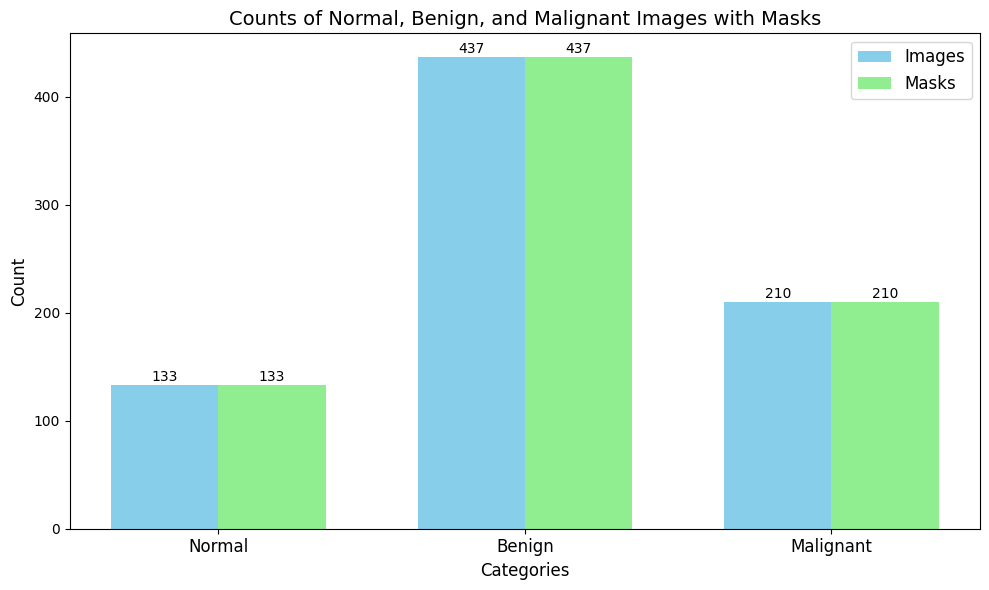

In [ ]:
plot_image_mask_counts(normal_count=len(normal_image), normal_mask_count=len(normal_mask),
                       benign_count=len(benign_image), benign_mask_count=len(benign_mask),
                       malignant_count=len(malignant_image), malignant_mask_count=len(malignant_mask))

/content/breast_data/main/mask_images/benign/benign(100)_mask.png
/content/breast_data/Dataset_BUSI_with_GT


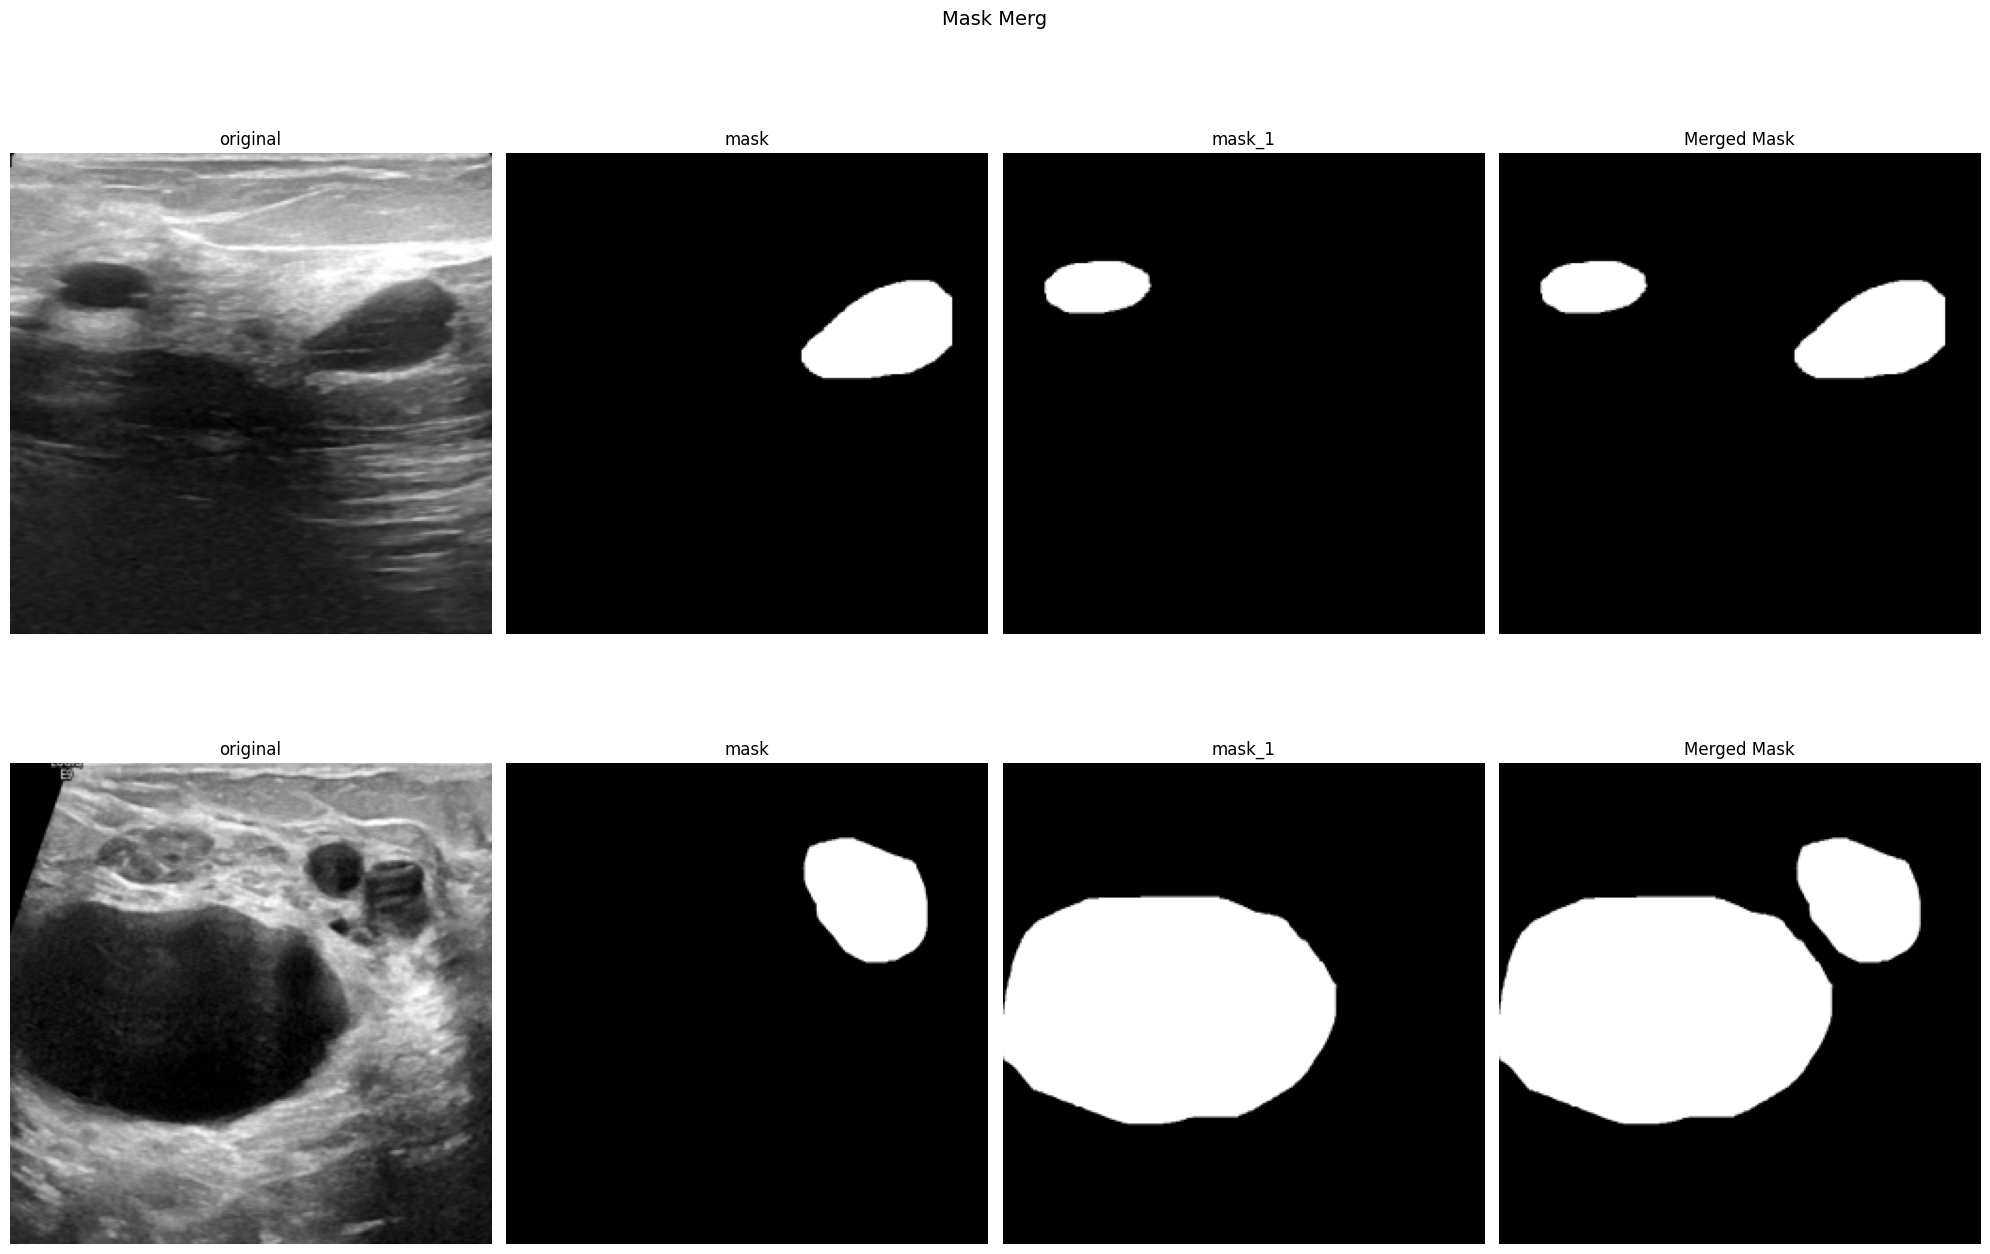

In [ ]:
normal_c_mask = natsorted(glob(os.path.join(data_dir_2, mask_images, "*.png"), recursive=True))
benign_c_mask = natsorted(glob(os.path.join(data_dir_2, mask_images_1, "*.png"), recursive=True))
malignant_c_mask = natsorted(glob(os.path.join(data_dir_2, mask_images_2, "*.png"), recursive=True))

print(benign_c_mask[99])
# Display a grid of images:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 14))
print(data_dir)
# Display images
show_image(ax[0, 0], benign_image[99], "original")
show_image(ax[0, 1], benign_mask[99], "mask")
show_image(ax[0, 2], benign_mask_1[8], "mask_1")
show_image(ax[0, 3], benign_c_mask[99], "Merged Mask")

show_image(ax[1, 0], benign_image[97], "original")
show_image(ax[1, 1], benign_mask[97], "mask")
show_image(ax[1, 2], benign_mask_1[7], "mask_1")
show_image(ax[1, 3], benign_c_mask[97], "Merged Mask")


plt.suptitle("Mask Merg", fontsize=14)
plt.tight_layout()
plt.show()

### **Create train, validation and test folders to hold the splitted data.**

In [ ]:
# images
train_main_images = "../train/images/normal"
train_main_images_1 = "../train/images/benign"
train_main_images_2 = "../train/images/malignant"
# masks
train_mask_images = "../train/mask/normal"
train_mask_images_1 = "../train/mask/benign"
train_mask_images_2 = "../train/mask/malignant"
# images
valid_main_images = "../validation/images/normal"
valid_main_images_1 = "../validation/images/benign"
valid_main_images_2 = "../validation/images/malignant"
# masks
valid_mask_images = "../validation/mask/normal"
valid_mask_images_1 = "../validation/mask/benign"
valid_mask_images_2 = "../validation/mask/malignant"
# images
test_main_images = "../test/images/normal"
test_main_images_1 = "../test/images/benign"
test_main_images_2 = "../test/images/malignant"
# masks
test_mask_images = "../test/mask/normal"
test_mask_images_1 = "../test/mask/benign"
test_mask_images_2 = "../test/mask/malignant"

# create the directories for train.
create_directory(os.path.join(data_dir, train_main_images))
create_directory(os.path.join(data_dir, train_mask_images))
# create the directories for validation.
create_directory(os.path.join(data_dir, valid_main_images))
create_directory(os.path.join(data_dir, valid_mask_images))
# create the directories for test.
create_directory(os.path.join(data_dir, test_main_images))
create_directory(os.path.join(data_dir, test_mask_images))

In [ ]:
# images and masks
images = natsorted(glob(os.path.join(os.path.join(data_dir_2, main_images), '*(*).png'), recursive=True))
benign_images = natsorted(glob(os.path.join(os.path.join(data_dir_2, main_images_1), '*(*).png'), recursive=True))
malignant_images = natsorted(glob(os.path.join(os.path.join(data_dir_2, main_images_2), '*(*).png'), recursive=True))

images_masks = natsorted(glob(os.path.join(os.path.join(data_dir_2, mask_images), '*.png'), recursive=True))
benign_images_masks = natsorted(glob(os.path.join(os.path.join(data_dir_2, mask_images_1), '*.png'), recursive=True))
malignant_images_masks = natsorted(glob(os.path.join(os.path.join(data_dir_2, mask_images_2), '*.png'), recursive=True))

### **Split for image and mask into validation, test and train - Data Preprocessing**

In [ ]:
# for benign images.
train_images_2, test_images_2, train_masks_2, test_masks_2 = train_test_split(
    benign_images, benign_images_masks, test_size=0.1, random_state=56
)
# Further split the training set into training and validation sets (75% train, 25% validation)
train_images_2, val_images_2, train_masks_2, val_masks_2 = train_test_split(
    train_images_2, train_masks_2, test_size=0.25, random_state=56
)

In [ ]:
# for malignant images.
train_images_3, test_images_3, train_masks_3, test_masks_3 = train_test_split(
    malignant_images, malignant_images_masks, test_size=0.1, random_state=56
)
# Further split the training set into training and validation sets (75% train, 25% validation)
train_images_3, val_images_3, train_masks_3, val_masks_3 = train_test_split(
    train_images_3, train_masks_3, test_size=0.25, random_state=56
)

In [ ]:
train_images_2.extend(train_images_3)
train_masks_2.extend(train_masks_3)

val_images_2.extend(val_images_3)
val_masks_2.extend(val_masks_3)

test_images_2.extend(test_images_3)
test_masks_2.extend(test_masks_3)

In [ ]:
# load into folders for images.
load_normal_images(os.path.join(data_dir, train_main_images), train_images_2)
load_normal_images(os.path.join(data_dir, valid_main_images), val_images_2)
load_normal_images(os.path.join(data_dir, test_main_images), test_images_2)
# load into folders for masks.
load_masks(os.path.join(data_dir, train_mask_images), train_masks_2)
load_masks(os.path.join(data_dir, valid_mask_images), val_masks_2)
load_masks(os.path.join(data_dir, test_mask_images), test_masks_2)

### **Data Augmentation - for improving the number of images and masks**

In [ ]:
# Data preprocessing - normalize data for both training and validation sets
# Inspired by: Ideas from various sources on image data augmentation

seed = 56  # Seed for consistent image and mask transformations
IMG_SIZE = (256, 256)
batch_size = 6

# Image data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=45,
    height_shift_range=0.5
)

val_datagen = ImageDataGenerator(rescale=1. / 255)

# Configure generators for training images and masks (disc)
train_image_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, "../train/images/"),
    target_size=IMG_SIZE, batch_size=batch_size, class_mode=None,
    seed=seed, shuffle=False, subset="training", color_mode="rgb"
)

train_mask_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, "../train/mask"),
    target_size=IMG_SIZE, batch_size=batch_size, class_mode=None,
    seed=seed, shuffle=False, color_mode="grayscale"
)

# Configure generators for validation images and masks (disc)
val_image_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, "../validation/images"),
    target_size=IMG_SIZE, batch_size=batch_size, class_mode=None,
    seed=seed, shuffle=False, color_mode="rgb"
)

val_mask_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, "../validation/mask"),
    target_size=IMG_SIZE, batch_size=batch_size, class_mode=None,
    seed=seed, shuffle=False, color_mode="grayscale"
)

# Combine generators for training and validation (disc)
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 435 images belonging to 1 classes.
Found 435 images belonging to 1 classes.
Found 147 images belonging to 1 classes.
Found 147 images belonging to 1 classes.


In [ ]:
# Custom Data Generator Function
def custom_generator(image_gen, mask_gen):
    while True:
        # Get image and mask batches
        image_batch = next(image_gen).astype(np.float32)  # Cast to float32
        mask_batch = next(mask_gen).astype(np.float32)  # Cast to float32

        # Ensure masks are binary (if necessary)
        mask_batch = (mask_batch > 0.5).astype(np.float32)

        yield (image_batch, mask_batch)

train_generator = custom_generator(train_image_generator, train_mask_generator)
val_generator = custom_generator(val_image_generator, val_mask_generator)

### **Model building, using UNET and Attention UNET.**

In [ ]:
# Unet Architecture.
class UNet:
    """
    A class to represent a U-Net model for semantic segmentation.
    """

    def __init__(self, input_shape):
        """
        Initialize the U-Net model with the given input shape.

        Args:
        - input_shape (tuple): Shape of the input tensor (height, width, channels).
        """
        self.input_shape = input_shape

    def convolutional_block(self, input_layer, filters):
        """
        Build a convolutional block with two Conv2D layers, BatchNormalization, and ReLU activation.

        Args:
        - input_layer (tensor): Input tensor for the block.
        - filters (int): Number of filters for the convolutional layers.

        Returns:
        - tensor: Output tensor after processing through the convolutional block.
        """
        # First convolutional layer
        x = Conv2D(filters, kernel_size=3, padding="same", kernel_initializer="he_normal")(input_layer)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        # Second convolutional layer
        x = Conv2D(filters, kernel_size=3, padding="same", kernel_initializer="he_normal")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        return x

    def encoder_block(self, input_layer, filters, drop_rate):
        """
        Create an encoder block consisting of a convolutional block followed by MaxPooling and Dropout.

        Args:
        - input_layer (tensor): Input tensor for the encoder block.
        - filters (int): Number of filters for the convolutional layers.
        - drop_rate (float): Dropout rate for the Dropout layer.

        Returns:
        - tuple: A tuple of tensors (skip_connection, pooled_output) where:
                 - skip_connection: Tensor after the convolutional block for skip connections.
                 - pooled_output: Tensor after MaxPooling and Dropout.
        """
        # Convolutional block
        conv_out = self.convolutional_block(input_layer, filters)

        # MaxPooling and Dropout
        pooled_output = MaxPooling2D(pool_size=(2, 2))(conv_out)
        pooled_output = Dropout(drop_rate)(pooled_output)

        return conv_out, pooled_output

    def decoder_block(self, input_layer, skip_connection, filters, drop_rate):
        """
        Construct a decoder block using Conv2DTranspose, skip connections, Dropout, and a convolutional block.

        Args:
        - input_layer (tensor): Input tensor for the decoder block (from the previous layer).
        - skip_connection (tensor): Tensor from the skip connection (from the encoder).
        - filters (int): Number of filters for the convolutional layers.
        - drop_rate (float): Dropout rate for the Dropout layer.

        Returns:
        - tensor: Output tensor after processing through the decoder block.
        """
        # Upsampling using Conv2DTranspose
        x = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding="same")(input_layer)
        x = Concatenate()([x, skip_connection])

        # Dropout layer
        x = Dropout(drop_rate)(x)

        # Convolutional block
        x = self.convolutional_block(x, filters)

        return x

    def build_unet(self):
        """
        Assemble and return a U-Net model for semantic segmentation.

        Returns:
        - keras.Model: The complete U-Net model.
        """
        # Input layer
        inputs = Input(shape=self.input_shape)

        # Encoder pathway
        skip1, pool1 = self.encoder_block(inputs, 64, 0.1)
        skip2, pool2 = self.encoder_block(pool1, 128, 0.1)
        skip3, pool3 = self.encoder_block(pool2, 256, 0.1)
        skip4, pool4 = self.encoder_block(pool3, 512, 0.1)

        # Bridge layer
        bridge = self.convolutional_block(pool4, 1024)

        # Decoder pathway
        decode1 = self.decoder_block(bridge, skip4, 512, 0.1)
        decode2 = self.decoder_block(decode1, skip3, 256, 0.1)
        decode3 = self.decoder_block(decode2, skip2, 128, 0.1)
        decode4 = self.decoder_block(decode3, skip1, 64, 0.1)

        # Output layer
        outputs = Conv2D(1, kernel_size=(1, 1), padding="same", activation="sigmoid")(decode4)

        # Model creation
        unet_model = Model(inputs, outputs, name="breast_u-net")

        return unet_model

In [ ]:
# Attention UNET
import tensorflow.keras.layers as L

def conv_block(x, num_filters, activation='relu', use_batch_norm=True, dropout_rate=0.0, kernel_initializer="he_normal"):
    """
    Convolutional Block with optional Batch Normalization and Dropout.

    Parameters:
        x (tensor): Input tensor to the convolutional block.
        num_filters (int): Number of filters for the convolutional layers.
        activation (str): Activation function for the convolutional layers.
        use_batch_norm (bool): Whether to use Batch Normalization.
        dropout_rate (float): Dropout rate for regularization.
        kernel_initializer (str): Initializer for kernel weights.

    Returns:
        tensor: Output tensor after applying convolutions.
    """
    x = L.Conv2D(num_filters, 3, padding="same", kernel_initializer=kernel_initializer)(x)
    if use_batch_norm:
        x = L.BatchNormalization()(x)
    x = L.Activation(activation)(x)

    x = L.Conv2D(num_filters, 3, padding="same", kernel_initializer=kernel_initializer)(x)
    if use_batch_norm:
        x = L.BatchNormalization()(x)
    x = L.Activation(activation)(x)

    if dropout_rate > 0:
        x = L.Dropout(dropout_rate)(x)

    return x


def encoder_block(x, num_filters, activation='relu', use_batch_norm=True, dropout_rate=0.0, kernel_initializer="he_normal"):
    """
    Encoder Block with Convolutional and MaxPooling layers.

    Parameters:
        x (tensor): Input tensor to the encoder block.
        num_filters (int): Number of filters for the convolutional layers.
        activation (str): Activation function for the convolutional layers.
        use_batch_norm (bool): Whether to use Batch Normalization.
        dropout_rate (float): Dropout rate for regularization.
        kernel_initializer (str): Initializer for kernel weights.

    Returns:
        tuple: Output of the convolutional block and pooling layer.
    """
    x = conv_block(x, num_filters, activation, use_batch_norm, dropout_rate, kernel_initializer)
    p = L.MaxPool2D((2, 2))(x)
    return x, p


def attention_gate(g, s, num_filters, use_batch_norm=True, kernel_initializer="he_normal"):
    """
    Attention Gate to focus on relevant features in the skip connection.

    Parameters:
        g (tensor): Input tensor from the decoder.
        s (tensor): Skip connection tensor from the encoder.
        num_filters (int): Number of filters for the attention mechanism.
        use_batch_norm (bool): Whether to use Batch Normalization.
        kernel_initializer (str): Initializer for kernel weights.

    Returns:
        tensor: Output tensor after applying the attention mechanism.
    """
    Wg = L.Conv2D(num_filters, 1, padding="same", kernel_initializer=kernel_initializer)(g)
    if use_batch_norm:
        Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same", kernel_initializer=kernel_initializer)(s)
    if use_batch_norm:
        Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same", kernel_initializer=kernel_initializer)(out)
    out = L.Activation("sigmoid")(out)

    return out * s


def decoder_block(x, s, num_filters, activation='relu', use_batch_norm=True, dropout_rate=0.0, kernel_initializer="he_normal"):
    """
    Decoder Block with Transposed Convolutional and Concatenation layers.

    Parameters:
        x (tensor): Input tensor to the decoder block.
        s (tensor): Skip connection tensor from the encoder.
        num_filters (int): Number of filters for the convolutional layers.
        activation (str): Activation function for the convolutional layers.
        use_batch_norm (bool): Whether to use Batch Normalization.
        dropout_rate (float): Dropout rate for regularization.
        kernel_initializer (str): Initializer for kernel weights.

    Returns:
        tensor: Output tensor after applying transposed convolutions and concatenations.
    """
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters, use_batch_norm, kernel_initializer)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters, activation, use_batch_norm, dropout_rate, kernel_initializer)
    return x


def attention_unet(input_shape, num_classes=1, activation='relu', final_activation='sigmoid', use_batch_norm=True, dropout_rate=0.0, kernel_initializer="he_normal"):
    """
    Builds the Attention U-Net model for image segmentation.

    Parameters:
        input_shape (tuple): Shape of the input tensor (height, width, channels).
        num_classes (int): Number of output classes.
        activation (str): Activation function for hidden layers.
        final_activation (str): Activation function for the output layer.
        use_batch_norm (bool): Whether to use Batch Normalization.
        dropout_rate (float): Dropout rate for regularization.
        kernel_initializer (str): Initializer for kernel weights.

    Returns:
        Model: Attention U-Net model for segmentation tasks.
    """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64, activation, use_batch_norm, dropout_rate, kernel_initializer)
    s2, p2 = encoder_block(p1, 128, activation, use_batch_norm, dropout_rate, kernel_initializer)
    s3, p3 = encoder_block(p2, 256, activation, use_batch_norm, dropout_rate, kernel_initializer)

    """ Bottleneck """
    b1 = conv_block(p3, 512, activation, use_batch_norm, dropout_rate, kernel_initializer)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256, activation, use_batch_norm, dropout_rate, kernel_initializer)
    d2 = decoder_block(d1, s2, 128, activation, use_batch_norm, dropout_rate, kernel_initializer)
    d3 = decoder_block(d2, s1, 64, activation, use_batch_norm, dropout_rate, kernel_initializer)

    """ Output """
    outputs = L.Conv2D(num_classes, 1, padding="same", activation=final_activation)(d3)

    """ Model """
    model = Model(inputs, outputs, name="Breast-Attention-UNET")
    return model

### **Model Building for UNET.**

In [ ]:
config =  tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=0'

### **model compilation and training.**

In [ ]:
epochs = 60
batch = 6
lr = 7e-5

metrics = [dice_coefficient, intersection_over_union]
loss = [dice_loss]

In [ ]:
# Environment setup
def setup_environment(data_dir):
    """
    Set up environment variables and create necessary directories.

    Args:
        data_dir (str): Directory for storing logs and models.

    Returns:
        log_file (str): Path to the logging directory.
    """
    log_file = os.path.join(data_dir, "files")
    os.makedirs(log_file, exist_ok=True)
    return log_file

# Model training and evaluation
def launch_model(log_file, train_images, val_images, csv_file, h5_file, lr, batch, epochs):
    """
    Train the U-Net model for optic disc segmentation.

    Args:
        log_file (str): Path to the directory for logging model and CSV files.
        train_images (str): Path to training images.
        val_images (str): Path to validation images.
        csv_file (str): Name of the CSV file for logging training history.
        h5_file (str): Name of the file for saving the best model.
        lr (float): Learning rate for the optimizer.
        batch (int): Batch size for training.
        epochs (int): Number of training epochs.

    Returns:
        model (tf.keras.Model): Compiled U-Net model.
        train_steps (int): Steps per epoch for training.
        val_steps (int): Steps per epoch for validation.
        model_path (str): Path to save the best model.
        csv_path (str): Path to save the training log.
    """
    BATCH = batch
    learning_rate = lr
    num_epochs = epochs
    model_path = os.path.join(log_file, h5_file)
    csv_path = os.path.join(log_file, csv_file)

    # Calculate steps per epoch for training and validation
    train_steps = len(train_images) // BATCH
    val_steps = len(val_images) // BATCH
    input_shape = (256, 256, 3)
    num_classes = 1  # Binary segmentation (cancer vs. background)
    # unet = UNet(input_shape=input_shape)
    # unet_model = unet.build_unet()
    unet_model = attention_unet(input_shape, num_classes, dropout_rate=0.1)

    print(unet_model.summary())
    return unet_model, train_steps, val_steps, model_path, csv_path

def train_model(model, train_generator, val_generator, num_epochs, train_steps, val_steps, model_path, csv_path, metrics, lr, loss):
    """
    Train the U-Net model.

    Args:
        model (tf.keras.Model): The U-Net model to train.
        train_generator (generator): Generator for training data.
        val_generator (generator): Generator for validation data.
        num_epochs (int): Number of training epochs.
        train_steps (int): Steps per epoch for training.
        val_steps (int): Steps per epoch for validation.
        model_path (str): Path to save the best model.
        csv_path (str): Path to save the training log.
        metrics (list): List of metrics to evaluate the model.
        lr (float): Learning rate for the optimizer.
        loss (list): Loss function(s) for training.

    Returns:
        history: Training history.
    """
    # Compile the model with the given loss, optimizer, and metrics
    model.compile(
        loss=loss,
        optimizer='adam',
        metrics=metrics
    )

    # Define the callbacks
    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        CSVLogger(csv_path),
        EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
        PlotLossesKeras(),
    ]

    # Train the model and return the history
    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        callbacks=callbacks,
    )

    return history


In [ ]:
# log_file = setup_environment(data_dir)
# model, train_steps, val_steps, model_path, csv_path = launch_model(
#     log_file, train_images_2, val_images_2, "breast_unet_file.csv", "breast_unet_file.keras", lr, batch, epochs
# )

In [ ]:
log_file = setup_environment(data_dir)
model, train_steps, val_steps, model_path, csv_path = launch_model(
    log_file, train_images_2, val_images_2, "breast_attention_unet_file.csv", "breast_attention_unet_file.keras", lr, batch, epochs
)

Model: "Breast-Attention-UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 64)   │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 128)  │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)       

 Total params: 8,143,169 (31.06 MB)

 Trainable params: 8,135,745 (31.04 MB)

 Non-trainable params: 7,424 (29.00 KB)

None


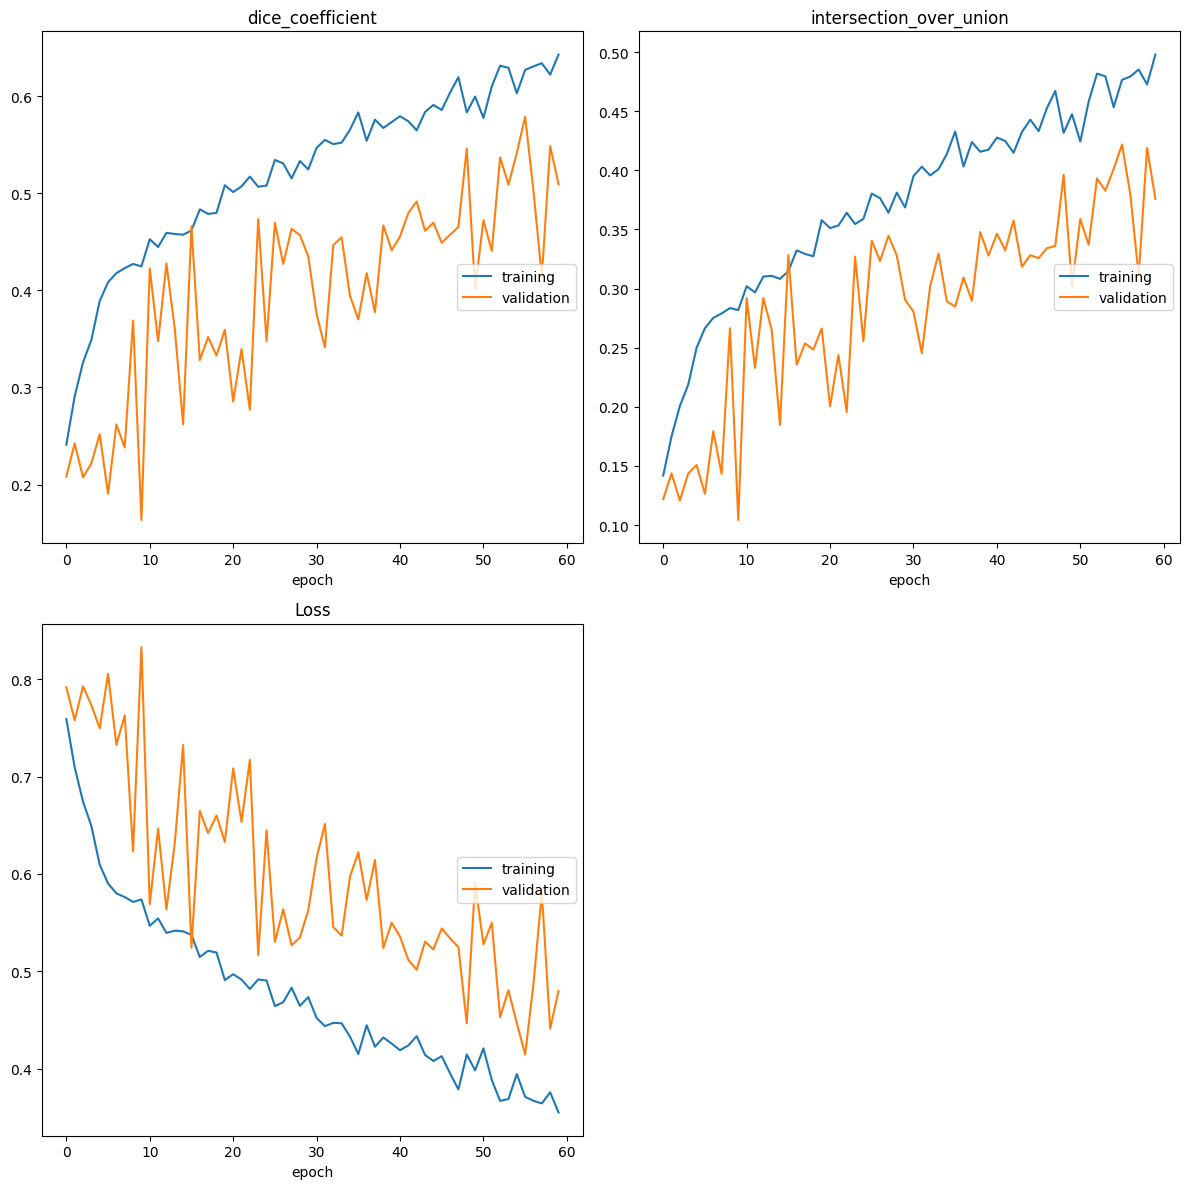

dice_coefficient
	training         	 (min:    0.241, max:    0.643, cur:    0.643)
	validation       	 (min:    0.164, max:    0.579, cur:    0.509)
intersection_over_union
	training         	 (min:    0.142, max:    0.498, cur:    0.498)
	validation       	 (min:    0.104, max:    0.422, cur:    0.376)
Loss
	training         	 (min:    0.355, max:    0.759, cur:    0.355)
	validation       	 (min:    0.415, max:    0.833, cur:    0.480)
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 486ms/step - dice_coefficient: 0.6329 - intersection_over_union: 0.4864 - loss: 0.3667 - val_dice_coefficient: 0.5094 - val_intersection_over_union: 0.3758 - val_loss: 0.4799


In [ ]:
history = train_model(model, train_generator, val_generator, epochs, train_steps, val_steps, model_path, csv_path, metrics, lr,loss)

### **Model prediction and Evaluation testing**

In [ ]:
import cv2 as cv
import numpy as np

def evaluate_segmentation(image_index, image_paths, mask_paths, breast_model, size = (256, 256)):
    """
    Evaluate the segmentation model's performance on a specific image.

    Args:
        image_index (int): Index of the image to process.
        image_paths (list): List of file paths for images to be tested.
        disc_gt_paths (list): List of ground truth paths for optic disc.
        cup_gt_paths (list): List of ground truth paths for optic cup.
        disc_model (keras.Model): Trained model for optic disc prediction.
        cup_model (keras.Model): Trained model for optic cup prediction.

    Returns:
        tuple: Results containing the original image, resized image,
               original and predicted segmentation overlays, CDR ratios,
               and predicted masks.
    """
    # Load the target image
    img = cv.imread(image_paths[image_index], cv.IMREAD_COLOR)
    # Preprocess image
    img = cv.resize(img, size, interpolation=cv.INTER_AREA) / 255.0  # Resize and normalize
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict mask
    pred_mask = model.predict(img)[0]
    pred_mask = np.where(pred_mask > 0.5, 1.0, 0.0)  # Binarize prediction
    pred_mask = np.squeeze(pred_mask, axis=-1)  # Remove single-dimensional entries
    pred_mask = cv.resize(pred_mask, size, interpolation=cv.INTER_AREA)

    img_for_display = img.copy()
    # Combine original disc and cup masks with the image for visualization
    predicted_breast = pred_mask

    return img_for_display, predicted_breast


In [ ]:
train_images = natsorted(glob(os.path.join(data_dir, train_main_images, '*.png'), recursive=True))
validation_images = natsorted(glob(os.path.join(data_dir, valid_main_images, '*.png'), recursive=True))
test_images = natsorted(glob(os.path.join(data_dir, test_main_images, '*.png'), recursive=True))

train_masks = natsorted(glob(os.path.join(data_dir, train_mask_images, '*.png'), recursive=True))
validation_masks = natsorted(glob(os.path.join(data_dir, valid_mask_images, '*.png'), recursive=True))
test_masks = natsorted(glob(os.path.join(data_dir, test_mask_images, '*.png'), recursive=True))

In [ ]:
# Define a function to predict masks and calculate Dice scores for a given dataset
def calculate_mean_dice_score(images, masks, model, size=(256, 256), smooth=3e-1):
    """
    Calculate the mean Dice score for a dataset.

    Args:
        images (list): List of image file paths.
        masks (list): List of mask file paths.
        model (tensorflow.keras.Model): Trained model for prediction.
        smooth:

    Returns:
        tuple: Mean Dice score and list of individual Dice scores.
    """
    dice_scores, image_new = {}, {}
    for img_path, mask_path in zip(images, masks):
        # Read image and mask
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        # Get the base name of the mask file
        mask_name = os.path.basename(mask_path)

        # Preprocess image
        img = cv.resize(img, size, interpolation=cv.INTER_AREA) / 255.0  # Resize and normalize
        img = img.astype(np.float32)
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        # Predict mask
        pred_mask = model.predict(img)[0]
        pred_mask = np.where(pred_mask > 0.5, 1.0, 0.0)  # Binarize prediction
        pred_mask = np.squeeze(pred_mask, axis=-1)  # Remove single-dimensional entries
        pred_mask = cv.resize(pred_mask, size, interpolation=cv.INTER_AREA)
        image_new[mask_name] = pred_mask
        mask = mask / 255.0  # Normalize mask

        # Calculate Dice score
        dice = dice_coefficient(mask.astype(np.float32), pred_mask.astype(np.float32)) + smooth
        dice_scores[mask_name] = float(dice)

    mean_dice = np.mean(list(dice_scores.values()))
    return mean_dice, dice_scores, image_new

In [ ]:
size = (256, 256)
train_mean_dice, train_dice_scores, train_img = calculate_mean_dice_score(train_images, train_masks, model, size)
val_mean_dice, val_dice_scores, val_img = calculate_mean_dice_score(validation_images, validation_masks, model, size)
test_mean_dice, test_dice_scores, test_img = calculate_mean_dice_score(test_images, test_masks, model, size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [ ]:
print(f'Mean Dice Score - Train: {train_mean_dice:.4f}')
print(f'Mean Dice Score - Validation: {val_mean_dice:.4f}')
print(f'Mean Dice Score - Test: {test_mean_dice:.4f}')

Mean Dice Score - Train: 0.8454
Mean Dice Score - Validation: 0.8524
Mean Dice Score - Test: 0.8550


In [ ]:
sorted_train_scores = sorted(train_dice_scores.items(), key=lambda item: item[1], reverse=True)
sorted_val_scores = sorted(val_dice_scores.items(), key=lambda item: item[1], reverse=True)
sorted_test_scores = sorted(test_dice_scores.items(), key=lambda item: item[1], reverse=True)

# Convert sorted lists of tuples back to dictionaries
sorted_train_dict = {name: score for name, score in sorted_train_scores}
sorted_val_dict = {name: score for name, score in sorted_val_scores}
sorted_test_dict = {name: score for name, score in sorted_test_scores}

train_names = list(sorted_train_dict.keys())[:5]
val_names = list(sorted_val_dict.keys())[:5]
test_names = list(sorted_test_dict.keys())[:5]

name_1 = train_names[0]
name_2 = val_names[0]
name_3 = test_names[0]

image_name_1 = name_1.split('_')[0]+".png"
image_name_2 = name_2.split('_')[0]+".png"
image_name_3 = name_3.split('_')[0]+".png"
print(image_name_1)
print(image_name_2)
print(image_name_3)

benign(434).png
benign(198).png
benign(264).png


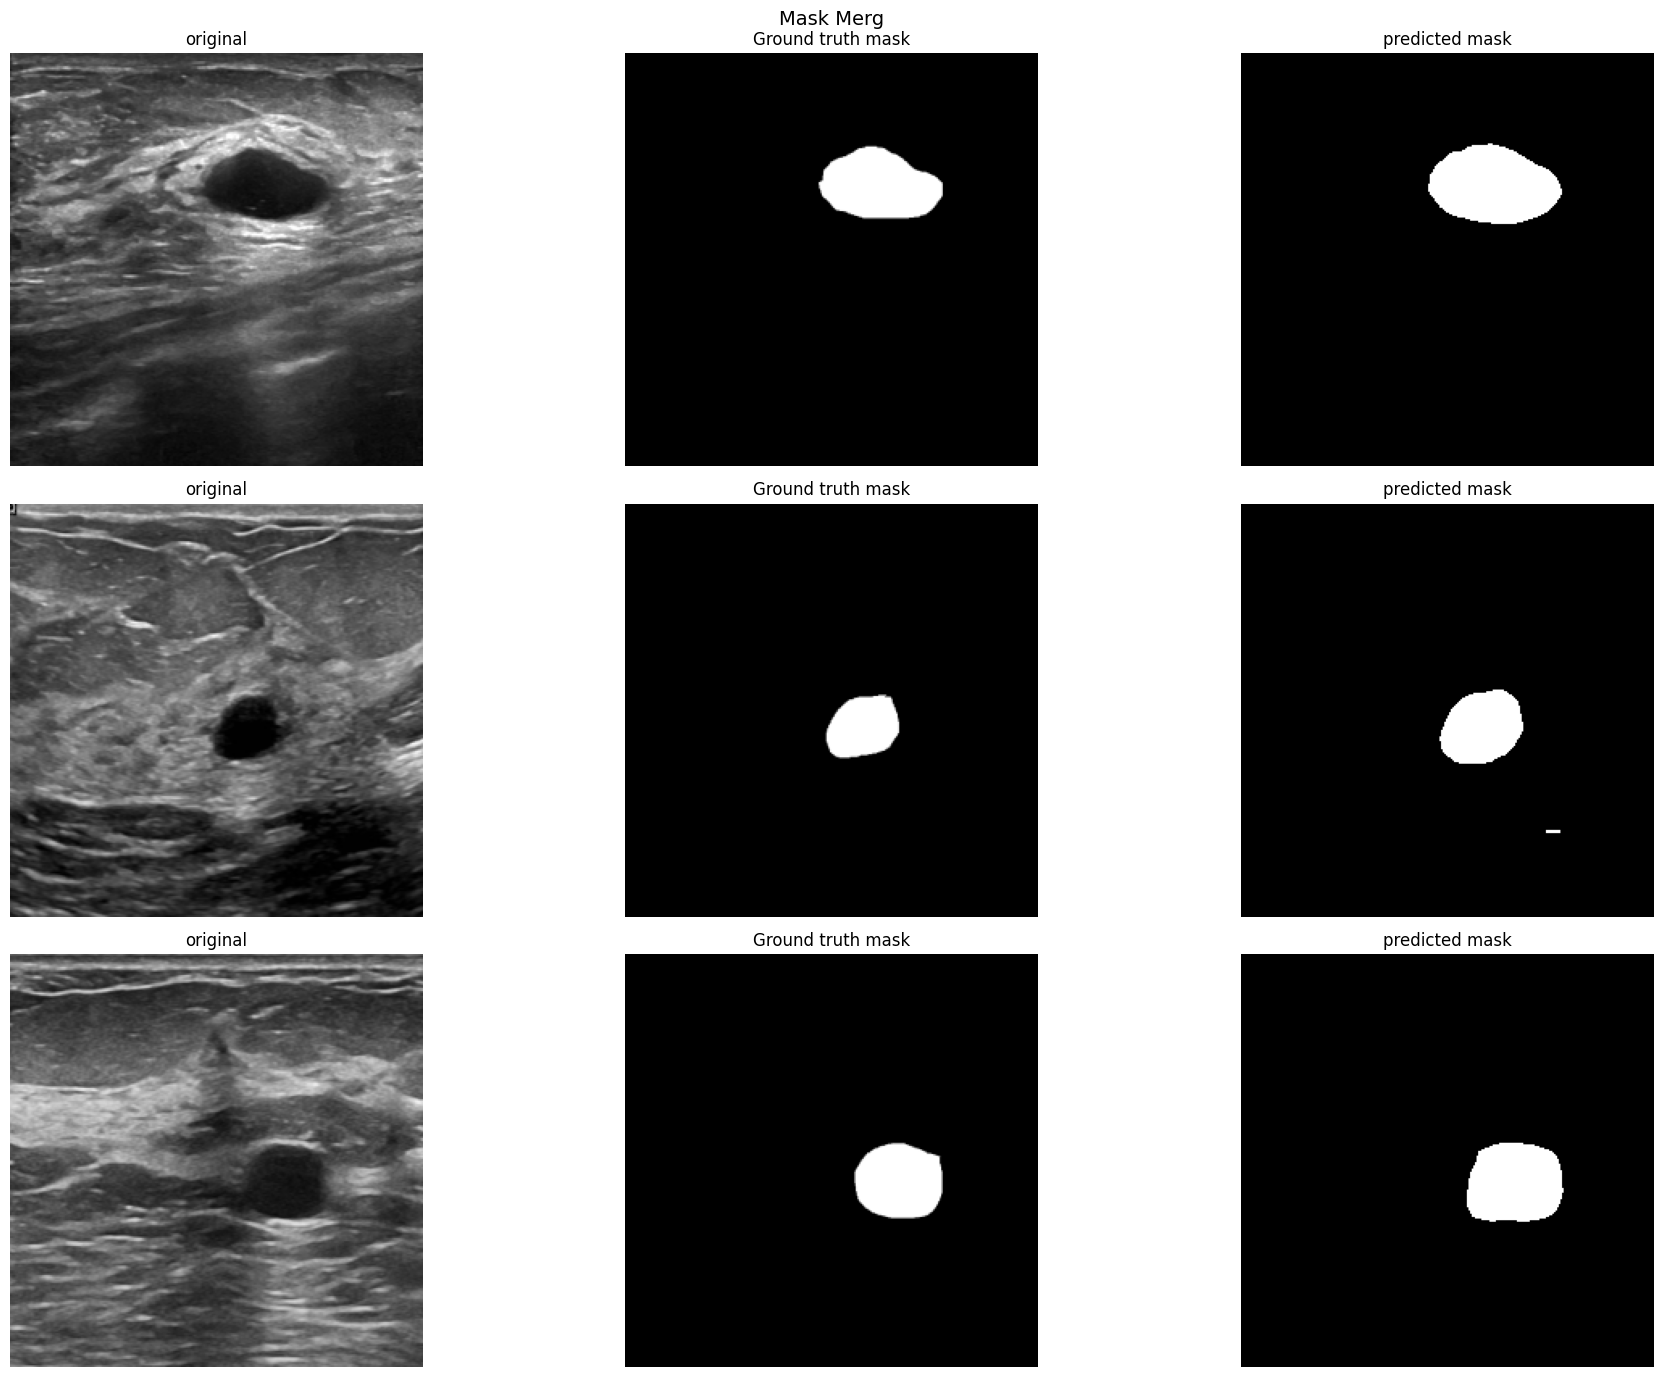

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 14))
# Display tumors images

show_image(ax[0, 0],os.path.join(data_dir, train_main_images, image_name_1) , "original")
show_image(ax[0, 1], os.path.join(data_dir, train_mask_images, name_1), "Ground truth mask")
show_image_read(ax[0, 2], train_img[name_1], "predicted mask")

show_image(ax[1, 0], os.path.join(data_dir, valid_main_images, image_name_2) , "original")
show_image(ax[1, 1], os.path.join(data_dir, valid_mask_images, name_2), "Ground truth mask")
show_image_read(ax[1, 2], val_img[name_2], "predicted mask")

show_image(ax[2, 0],os.path.join(data_dir, test_main_images, image_name_3) , "original")
show_image(ax[2, 1], os.path.join(data_dir, test_mask_images, name_3), "Ground truth mask")
show_image_read(ax[2, 2], test_img[name_3], "predicted mask")


plt.suptitle("Mask Merg", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
train_images = natsorted(glob(os.path.join(data_dir, train_main_images, '*.png'), recursive=True))
validation_images = natsorted(glob(os.path.join(data_dir, valid_main_images, '*.png'), recursive=True))
test_images = natsorted(glob(os.path.join(data_dir, test_main_images, '*.png'), recursive=True))

train_masks = natsorted(glob(os.path.join(data_dir, train_mask_images, '*.png'), recursive=True))
validation_masks = natsorted(glob(os.path.join(data_dir, valid_mask_images, '*.png'), recursive=True))
test_masks = natsorted(glob(os.path.join(data_dir, test_mask_images, '*.png'), recursive=True))

image_path = 4
print(validation_images[image_path])
print(validation_masks[image_path])

img_for_display, predicted_breast = evaluate_segmentation(image_path, validation_images, validation_masks, model, size)

/content/breast_data/Dataset_BUSI/Dataset_BUSI_with_GT/../validation/images/normal/benign(16).png
/content/breast_data/Dataset_BUSI/Dataset_BUSI_with_GT/../validation/mask/normal/benign(16)_mask.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


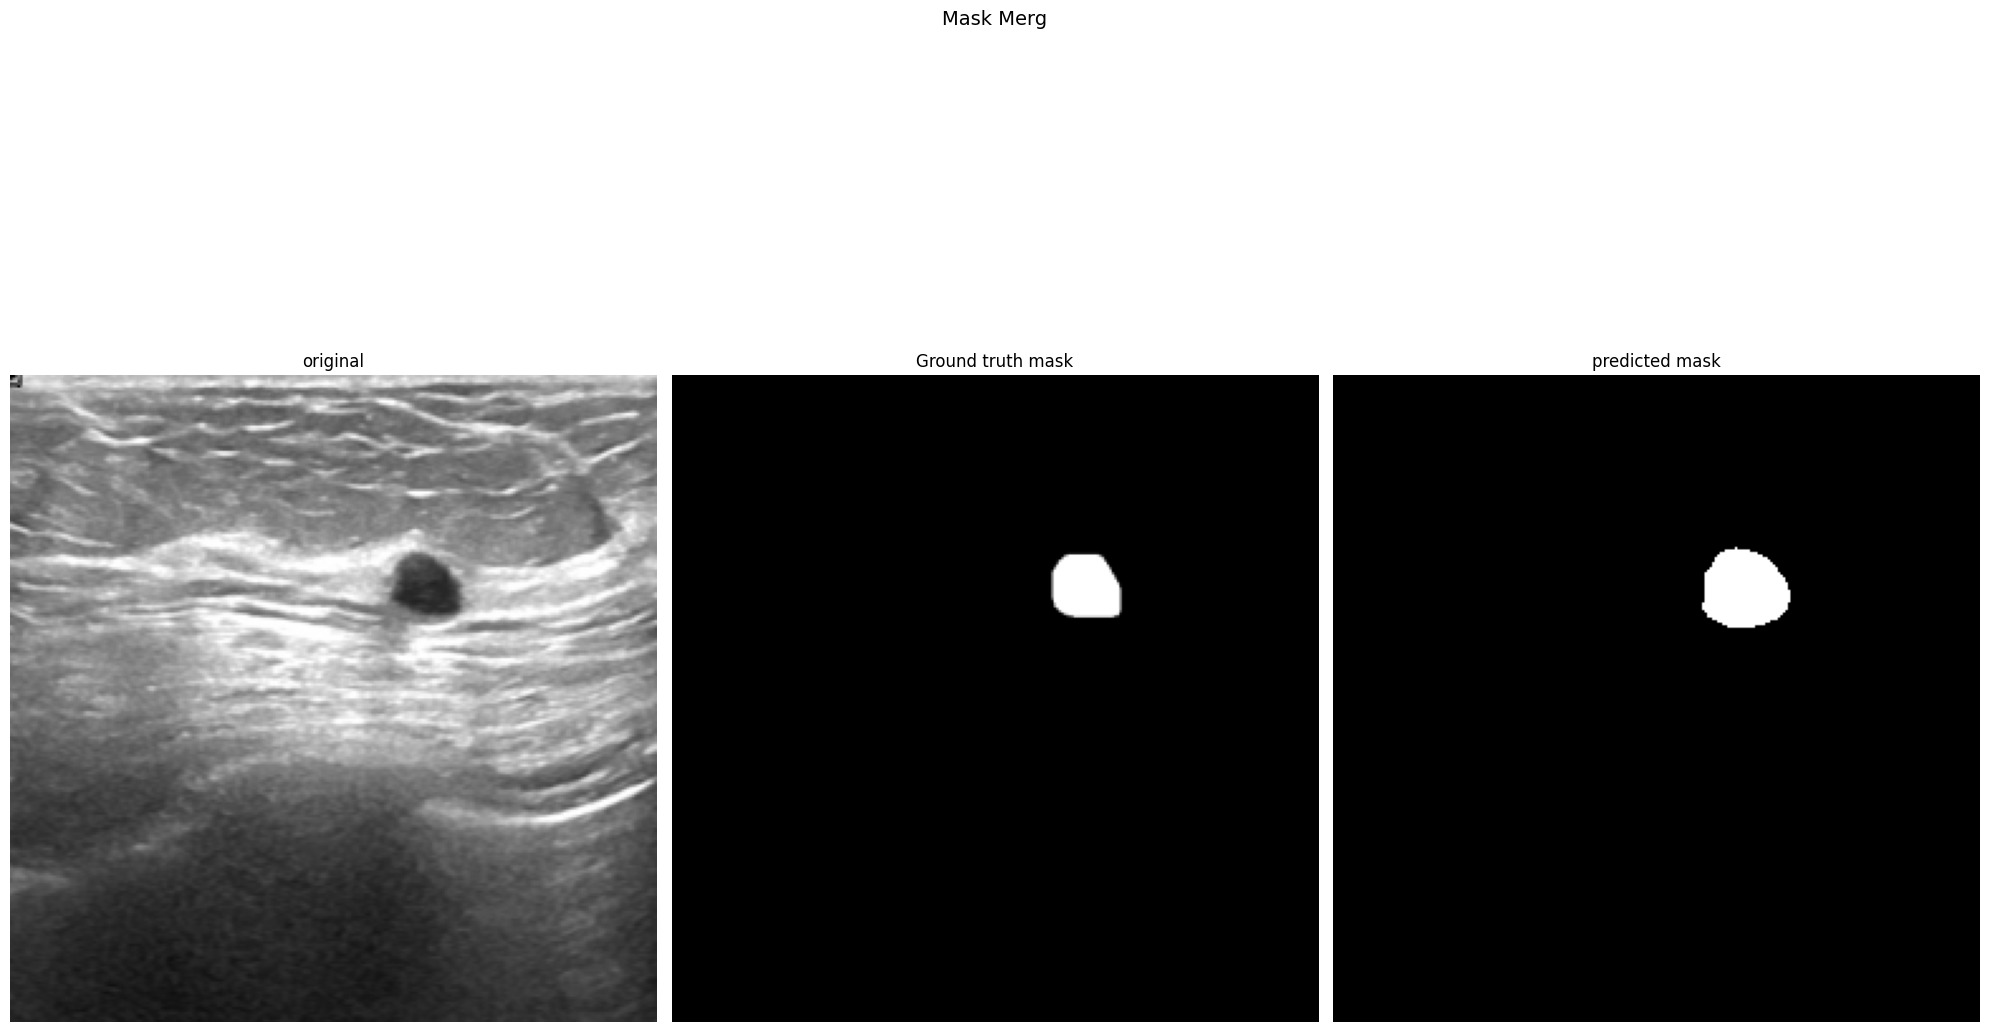

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 14))
# Display retina images

show_image(ax[0], validation_images[image_path], "original")
show_image(ax[1], validation_masks[image_path], "Ground truth mask")
show_image_read(ax[2], predicted_breast, "predicted mask")


plt.suptitle("Mask Merg", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Find the last convolutional layer automatically
def get_last_conv_layer(model):
    """
    Find the last convolutional layer in the model.

    Parameters:
        model (Model): The Keras model instance.

    Returns:
        str: Name of the last convolutional layer.
    """
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            return layer.name
    return None

# Get the last convolutional layer
last_conv_layer_name = get_last_conv_layer(model)
print("Last Conv Layer:", last_conv_layer_name)

Last Conv Layer: conv2d_23


### **Explainability using GRAD CAM**

> Add blockquote

> Add blockquote





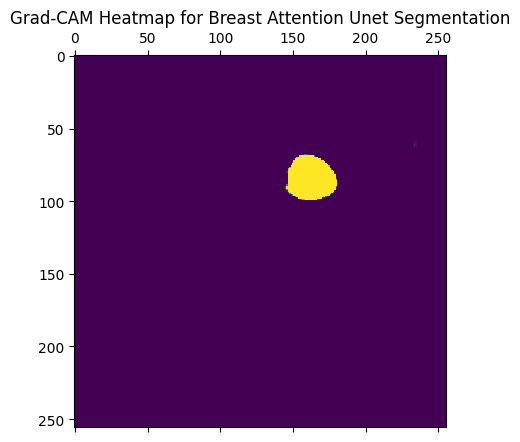

In [ ]:
def load_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image to range [0, 1]
    return img_array

img_path = validation_images[image_path]  # Replace with your image path
input_image = load_image(img_path)

def compute_gradcam(model, img_array, last_conv_layer_name):
    """
    Compute Grad-CAM for a segmentation model.

    Parameters:
        model (Model): The segmentation model.
        img_array (numpy.array): Preprocessed input image.
        last_conv_layer_name (str): Name of the last convolutional layer.

    Returns:
        numpy.array: Heatmap of the Grad-CAM.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use a GradientTape to compute the gradients of the loss with respect to the last convolutional layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = tf.reduce_mean(predictions)  # Average over all pixels

    # Compute gradients of the loss with respect to the last convolutional layer output
    grads = tape.gradient(loss, conv_outputs)

    # Pool the gradients across the spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the output feature map by the pooled gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU to the heatmap to keep only positive values
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Use the last convolutional layer before the output
last_conv_layer_name = last_conv_layer_name  # Update this based on your model summary

# Compute Grad-CAM
heatmap = compute_gradcam(model, input_image, last_conv_layer_name)

# Display the heatmap
plt.matshow(heatmap)
plt.title("Grad-CAM Heatmap for Breast Attention Unet Segmentation")
plt.show()

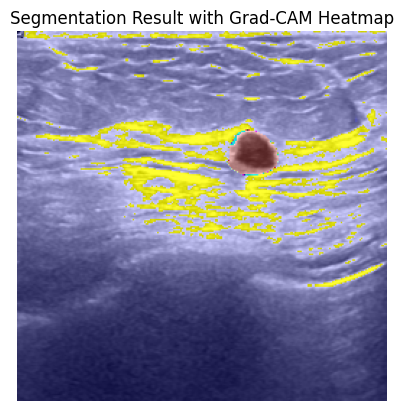

In [ ]:
def overlay_heatmap(heatmap, img_path, alpha=0.4, colormap='jet'):
    """
    Overlay the heatmap on the original image.

    Parameters:
        heatmap (numpy.array): The Grad-CAM heatmap.
        img_path (str): Path to the original image.
        alpha (float): Transparency of the overlay.
        colormap (str): Colormap for the heatmap.

    Returns:
        numpy.array: Image with overlayed heatmap.
    """
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale the heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use a colormap to colorize the heatmap
    colormap = plt.cm.get_cmap(colormap)
    colored_heatmap = colormap(heatmap)

    # Create an image with RGB colors from the colormap
    colored_heatmap = np.uint8(colored_heatmap[:, :, :3] * 255)

    # Superimpose the heatmap onto the original image
    superimposed_img = colored_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    return superimposed_img

# Overlay heatmap on the original image
superimposed_img = overlay_heatmap(heatmap, img_path)

# Display the result
plt.imshow(superimposed_img)
plt.axis('off')
plt.title("Segmentation Result with Grad-CAM Heatmap")
plt.show()